# Goals of this project
The aim of this project was to act as a simple exploratory project to practice building a fairly fundamental tool in NLP.

I learned the concepts behind the word2vec model, and while it was fairly understandable I wanted to see how it would translate to code.

I also got to practice working more with the pytorch library as a result, which was a big win.

The biggest challenge for me in building this was getting the vector dimensions right for matrix multiplication. Learning to respect that process and approach it slowly was valuable.



In [7]:
import re
import random
import torch.nn as nn
import torch
import numpy as np
from fastcore import *
from nbdev.showdoc import *
from tqdm import tqdm
import pickle as pkl

## Data ingestion
Here we define some functions for reading in and cleaning the data.

The primary data cleaning involves removing any characters which aren't letters as well making all those letters lowercase. 
We also remove all whitespace except for single spaces between words.

We want to remove words which do not carry much semantic weight on their own, which we will call stop words. We simply filter these out of the data.

In [8]:
def read_file(file_name):
    with open(file_name, 'r') as f:
        data = f.read()
    return data

def remove_non_alpha_characters(data):
    data = data.lower()
    # use regex to remove all non-alphanumeric characters
    data = re.sub(r'[^a-zA-Z\s]', '', data)
    # use regex to remove all whitespace characters
    data = re.sub(r'\s+', ' ', data)
    return data


def remove_stopwords(data):
    stopwords = ['a', 'an', 'the', 'and', 'or', 'but', 'if', 'then', 'else', 'when', 'at', 'from', 'by', 'on', 'off', 'for', 'in', 'out', 'over', 'to', 'into', 'with', ""]
    data = [word for word in data if word not in stopwords]
    return data


In [9]:
raw_data = read_file('shakespeare.txt')

data = remove_non_alpha_characters(raw_data)
data = data.split(" ")
data = remove_stopwords(data)

Here we create our dictionary of unique words which we will use for defining our embeddings.

We make this into a dictionary so that later we can refer to these values and get an index from each one.

In [10]:
unique_words = set(list(data))
unique_dict = {word: i for i, word in enumerate(unique_words)}

### Create a train loader and dataset
Here we create a train_loader that will randomly generate samples for us to use during training.

We choose a large batch size as this task does not demand a great deal of memory and larger batches help with training speed.

We define only the functions here and call them later so that all hyper parameters can be defined and run in one place.


In [11]:
def return_list_without_a_value(data, value):
    return [x for x in data if x != value]

def create_dataset(window_size, data):
    dataset = []

    for index, val in enumerate(data):
        sub = data[max(0,index-window_size):index]
        sub.extend(data[index+1:min(index+window_size, len(data))])
        for target in sub:
            dataset.append((unique_dict[val],unique_dict[target]))
    return dataset  

def create_dataloader(dataset, batch_size):
    train_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
    return train_loader


## Defining our model

Here we define our skipgram model class.

We take advantage of the built in pytorch module and embedding class to create our vector embeddings and handle the updating of our embedding weights.

Our embeddings are essentially just matrices with dimensions matching the size of our dictionary and the embedding size we choose to represent the different features that will emerge from our data.

One thing to take note of is how we initialise our weights. Currently we simply use a normal distribution with a mean of 0 and std_deviation of 0.1. It is possible there are better initialisations to use here.
We also use sparse embeddings many of the values will be very close to, or at 0.


In [18]:
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.u_embeddings = nn.Embedding(vocab_size, embedding_dim, sparse=True)
        self.v_embeddings = nn.Embedding(vocab_size, embedding_dim, sparse=True)
        self.init_emb()

    def init_emb(self):
        init_mean = 0
        init_std = 0.1
        self.u_embeddings.weight.data.normal_(init_mean, init_std)
        self.v_embeddings.weight.data.normal_(init_mean, init_std)

    def forward(self, pos_u, pos_v, neg_v):
        emb_u = self.u_embeddings(pos_u).view(-1, 1, self.embedding_dim).squeeze()
        emb_v = self.v_embeddings(pos_v).view(-1, self.embedding_dim).squeeze()

        score = torch.bmm(emb_u.unsqueeze(1), emb_v.unsqueeze(2)).squeeze()
        score = torch.sigmoid(score)

        neg_emb_v = self.v_embeddings(neg_v).view(-1, self.embedding_dim, neg_v.shape[1])

        neg_score = torch.bmm(emb_u.unsqueeze(1), neg_emb_v).squeeze()
        neg_score = torch.sigmoid(neg_score)

        return score, neg_score


    
    def forward_without_negatives(self, word1, word2):
        """This lets us do a simple vector comparison rather than doing a full forward pass."""""
        pos_u = torch.tensor([unique_dict[word1]])
        pos_v = torch.tensor([unique_dict[word2]])
        emb_u = self.u_embeddings(pos_u).view(-1, 1, self.embedding_dim).squeeze()
        emb_v = self.v_embeddings(pos_v).view(-1, self.embedding_dim).squeeze()
        score = torch.dot(emb_u, emb_v)
        score = torch.sigmoid(score)
        return score

    def get_dict_embeddings(self):
        return self.u_embeddings.weight.data.cpu().numpy()
    
    def get_embedding_from_word(self, word):
        index = unique_dict[word]
        return self.u_embeddings.weight.data[index]
    
    def get_embedding_from_index(self, index):
        return self.u_embeddings.weight.data[index]

    def save_embedding(self, file_name):
        # Save embedding lookup table as pkl file
        with open(file_name, 'wb') as f:
            pkl.dump(self.u_embeddings.weight.data.cpu().numpy(), f)
    
    def import_embeddings(self, file_name):
        with open(file_name, 'rb') as f:
            self.u_embeddings.weight.data = torch.from_numpy(pkl.load(f)).to(torch.float32)




### Loss function
Here we create a custom loss function which gives us a loss based on the model's error when predicting a 1 or 0 for the context word or randomly sampled words.

We use a custom loss function because it allows us to add weight decay to our training and capture the specific nature of what we want the model to improve at, which in this case is relatedness of words.


In [19]:

def loss_function(score, neg_score, lr, weight_decay, model):
    pos_loss = -torch.mean(torch.log(score))
    neg_loss = -torch.mean(torch.sum(torch.log(1 - neg_score), dim=1))
    loss = pos_loss + neg_loss
    # add L2 regularization term
    l2_loss = 0
    for param in model.parameters():
        l2_loss += torch.sum(param**2)
        loss += weight_decay * l2_loss
    return loss

## Training loop
This is the training loop for our model.

Our train loader iterator is declared every epoch and we then iterate over it according to our steps per epoch.

We generate our negative samples randomly at runtime as the cost of doing so is very low.

The parameters passed in for training have a massive impact on model performance. 
The length of negative samples should be somewhere between 5 and 20. Having a lower numbers means the model may stray into simply having all of its values tend to 1 which is not what we want. Thus a higher number is favoured.


In [20]:
def train(model, train_loader, batch_size, negative_sample_length, weight_decay, learning_rate, steps_per_epoch, epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    for epoch in range(epochs):
        loss_sum = 0
        train_loader_iter = iter(train_loader)
        for i in tqdm(range(steps_per_epoch)):
            x, y = next(train_loader_iter)
            pos_u = torch.tensor(x)
            pos_v = torch.tensor(y)
            neg_v = torch.randint(0, dictionary_length, (batch_size, negative_sample_length))
            optimizer.zero_grad()
            pos_score, neg_score = model(pos_u, pos_v, neg_v)
            loss = loss_function(pos_score, neg_score, learning_rate, weight_decay, model)
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()
        print("Epoch: {}, Loss: {}".format(epoch, loss_sum / steps_per_epoch))
    return model


## Instantiating our model

Here we instantiate our model with the embedding dimensions of our choice. 

The embedding dimensions are critical because they dictate how many "features" our vectors can contain. More dimensions mean richer vectors, with the trade off being longer trading times.

I find that 100 is a good number for getting sensible results on vector comparison, but even having very few can produce decent results.

I instantiate this in a different step than running the training loop as I don't necessarily want to throw away my weights every time.

In [21]:
embedding_dim = 100
dictionary_length = len(unique_words)
model = SkipGramModel(dictionary_length, embedding_dim)

# Training hyperparameters

The key hyperparameters we choose here are our window size, negative sample length, learning rate and weight decay.

* Window size: Determines the size of the context we will include for each of our unique words. We will take in x words from the left and right. Having a smaller window size(2-15) gives us a sense of the interchangeability of the words, while a larger window size (15 - 50) gives us a sense of the relatedness of the words.

* Negative sample length: To make the classifation task difficult for our model and avoid having it giving a score of 1 for relatedness on all words we need to have negative samples to make the problem harder. To get these samples we simply randomly sample from our dataset of unique words. The number of negative samples we use in each batch determines how many negative samples will be used for generating our negative score.

* Learning rate: The degree to which we update our weights with each pass. In this case we want a fairly low learning rate as higher rates tend to cause the model to not converge.

* Weight decay: Having some regularisation is important for this task as otherwise the weights tend to converge on very similar values. To avoid this we have the weights naturally decay over time. Small values seem to work for this task.

In [26]:
window_size = 2
batch_size = 32
learning_rate = 0.001
negative_sample_length = 15
weight_decay = 0.0006
steps_per_epoch = 300
epochs = 30

dataset = create_dataset(window_size , data) 
train_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

train(model, train_loader, batch_size, negative_sample_length, weight_decay, learning_rate, steps_per_epoch, epochs)

  0%|          | 0/300 [00:00<?, ?it/s]/var/folders/xr/3pxy4p9914ld14l6mxvvknvw0000gn/T/ipykernel_564/3371504634.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_u = torch.tensor(x)
/var/folders/xr/3pxy4p9914ld14l6mxvvknvw0000gn/T/ipykernel_564/3371504634.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_v = torch.tensor(y)
100%|██████████| 300/300 [00:04<00:00, 61.86it/s]


Epoch: 0, Loss: 15.062570985158285


100%|██████████| 300/300 [00:04<00:00, 63.54it/s]


Epoch: 1, Loss: 11.149217160542806


100%|██████████| 300/300 [00:04<00:00, 63.61it/s]


Epoch: 2, Loss: 11.097777713139852


100%|██████████| 300/300 [00:04<00:00, 63.92it/s]


Epoch: 3, Loss: 11.101737922032674


100%|██████████| 300/300 [00:04<00:00, 63.99it/s]


Epoch: 4, Loss: 11.10995981534322


100%|██████████| 300/300 [00:04<00:00, 64.15it/s]


Epoch: 5, Loss: 11.11240519841512


100%|██████████| 300/300 [00:04<00:00, 63.58it/s]


Epoch: 6, Loss: 11.088037172953287


100%|██████████| 300/300 [00:04<00:00, 63.70it/s]


Epoch: 7, Loss: 11.074867312113444


100%|██████████| 300/300 [00:04<00:00, 64.97it/s]


Epoch: 8, Loss: 11.039957389831542


100%|██████████| 300/300 [00:04<00:00, 64.10it/s]


Epoch: 9, Loss: 11.04225684483846


100%|██████████| 300/300 [00:04<00:00, 63.87it/s]


Epoch: 10, Loss: 11.003310381571453


100%|██████████| 300/300 [00:04<00:00, 63.87it/s]


Epoch: 11, Loss: 10.992491547266642


100%|██████████| 300/300 [00:04<00:00, 63.78it/s]


Epoch: 12, Loss: 10.9765771484375


100%|██████████| 300/300 [00:04<00:00, 63.95it/s]


Epoch: 13, Loss: 10.986021887461344


100%|██████████| 300/300 [00:04<00:00, 63.78it/s]


Epoch: 14, Loss: 10.978231426874796


100%|██████████| 300/300 [00:04<00:00, 63.90it/s]


Epoch: 15, Loss: 10.97792008082072


100%|██████████| 300/300 [00:04<00:00, 63.82it/s]


Epoch: 16, Loss: 10.953595498402914


100%|██████████| 300/300 [00:04<00:00, 63.30it/s]


Epoch: 17, Loss: 10.96350152015686


100%|██████████| 300/300 [00:04<00:00, 63.92it/s]


Epoch: 18, Loss: 10.95886812210083


100%|██████████| 300/300 [00:04<00:00, 63.85it/s]


Epoch: 19, Loss: 10.948883460362753


100%|██████████| 300/300 [00:04<00:00, 63.46it/s]


Epoch: 20, Loss: 10.942999130884806


100%|██████████| 300/300 [00:04<00:00, 63.47it/s]


Epoch: 21, Loss: 10.938583574295045


100%|██████████| 300/300 [00:04<00:00, 63.44it/s]


Epoch: 22, Loss: 10.956660776138305


100%|██████████| 300/300 [00:04<00:00, 63.25it/s]


Epoch: 23, Loss: 10.945172157287598


100%|██████████| 300/300 [00:04<00:00, 63.21it/s]


Epoch: 24, Loss: 10.945524829228718


100%|██████████| 300/300 [00:04<00:00, 63.38it/s]


Epoch: 25, Loss: 10.948882131576537


100%|██████████| 300/300 [00:04<00:00, 63.34it/s]


Epoch: 26, Loss: 10.936189915339153


100%|██████████| 300/300 [00:04<00:00, 63.39it/s]


Epoch: 27, Loss: 10.929907401402792


100%|██████████| 300/300 [00:04<00:00, 63.18it/s]


Epoch: 28, Loss: 10.945582799911499


100%|██████████| 300/300 [00:04<00:00, 63.31it/s]

Epoch: 29, Loss: 10.946145582199097


SkipGramModel(
  (u_embeddings): Embedding(30997, 100, sparse=True)
  (v_embeddings): Embedding(30997, 100, sparse=True)
)

# Testing
We now go to the testing phase to see how our model is performing.

### Testing functions
The following functions primarily exist to add, subtract and compare vectors. The goal is to produce intuitive results from the comparisons of our vectors.

Eg the following should have a high correlation:
flower and rose
man and king

man and woman

queen and woman
#### The following should have a low correlation
Flower and cart

concept and dog

power and table

In [27]:

def cos_sim(vector1, vector2):
    return np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))

def cos_sim_word(word1, word2):
    vector1 = get_emb(word1)
    vector2 = get_emb(word2)
    return np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))

def get_emb(word):
    return model.get_embedding_from_word(word)

def invert_dictionary(dictionary):
    return {v: k for k, v in dictionary.items()}

def get_closest_vector(vector):
    max = 0
    target = None
    for key,item in unique_dict.items():
        comparative = get_emb(key)
        comparison = cos_sim(vector, comparative)
        if comparison > max:
            max = comparison
            target = key

        
    return target


In [33]:
print(cos_sim_word("flower", "rose"),("flower", "rose"))
print(cos_sim_word("flower", "tree"), ("flower", "tree"))
print(cos_sim_word("flower", "dog"), ("flower", "dog"))
print(cos_sim_word("flower", "metal"), ("flower", "metal"))
print(cos_sim_word("flower", "cart"), ("flower", "cart"))
print(cos_sim_word("worm", "dog"), ("worm", "dog"))
print(cos_sim_word("king", "queen"), ("king", "queen"))
print(cos_sim_word("king", "royalty"), ("king", "royalty"))
print(cos_sim_word("queen", "royalty"), ("queen", "royalty"))
print(cos_sim_word("man", "king"), ("man", "king"))
print(cos_sim_word("woman", "king"), ("woman", "king"))
print(cos_sim_word("child", "prince"), ("child", "prince"))
print(cos_sim_word("child", "thought"), ("child", "thought"))


0.3508667 ('flower', 'rose')
0.09888135 ('flower', 'tree')
0.3795862 ('flower', 'dog')
0.03061111 ('flower', 'metal')
-inf ('flower', 'cart')
0.1650378 ('worm', 'dog')
0.9708709 ('king', 'queen')
0.15380333 ('king', 'royalty')
0.17624536 ('queen', 'royalty')
0.99405634 ('man', 'king')
0.97293115 ('woman', 'king')
0.94517046 ('child', 'prince')
0.91396743 ('child', 'thought')


/var/folders/xr/3pxy4p9914ld14l6mxvvknvw0000gn/T/ipykernel_564/221498206.py:7: RuntimeWarning: divide by zero encountered in float_scalars
  return np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))


This classic test still doesn't seem to work great

In [38]:
vector = get_emb("king") - get_emb("man") + get_emb("woman") 
closest_vector = get_closest_vector(vector)
print(closest_vector)

/var/folders/xr/3pxy4p9914ld14l6mxvvknvw0000gn/T/ipykernel_564/221498206.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  return np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))


waspish


Here we have the option to generate some common words. Currently I prefer using a small hand picked set

In [30]:


def find_most_common_words(words, n, m):
    word_counts = {}
    for word in words:
        if word not in word_counts:
            word_counts[word] = 0
        word_counts[word] += 1
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    sorted_words = [word[0] for word in sorted_words]
    return sorted_words[n:m]

common_words = find_most_common_words(data, 100, 200)

Save the embeddings using any filename you like

In [31]:
path = "embeddings.emb"
model.save_embedding(path)

Import the embeddings if you simply wish to display them without training

In [32]:
model.import_embeddings("embeddings.emb")

Here we choose some possibly interesting words to look at in our dataset, based on my poor knowledge of Shakespeare

In [34]:

words = ["king","queen", "prince", "princess", "knight","skull", "sword", "skull", "flower", "tree", "fool", "metal", "cart", "worm", "boy", "witch"]

## Displaying our results
Here we use principal component analysis to reduce our dimensions down to 2 so we can display them

In [35]:
from sklearn.decomposition import PCA

number_components = 2

embeddings = model.get_dict_embeddings()
pca = PCA(n_components=number_components)
reduced_embeddings= pca.fit_transform(embeddings)


### Display the embeddings
display embeddings visually using matplotlib. 

Each word is represented by a point in 2D space.

The x and y coordinates of the point are the first and second dimensions of the word's embedding.

The words are labeled by their actual word.

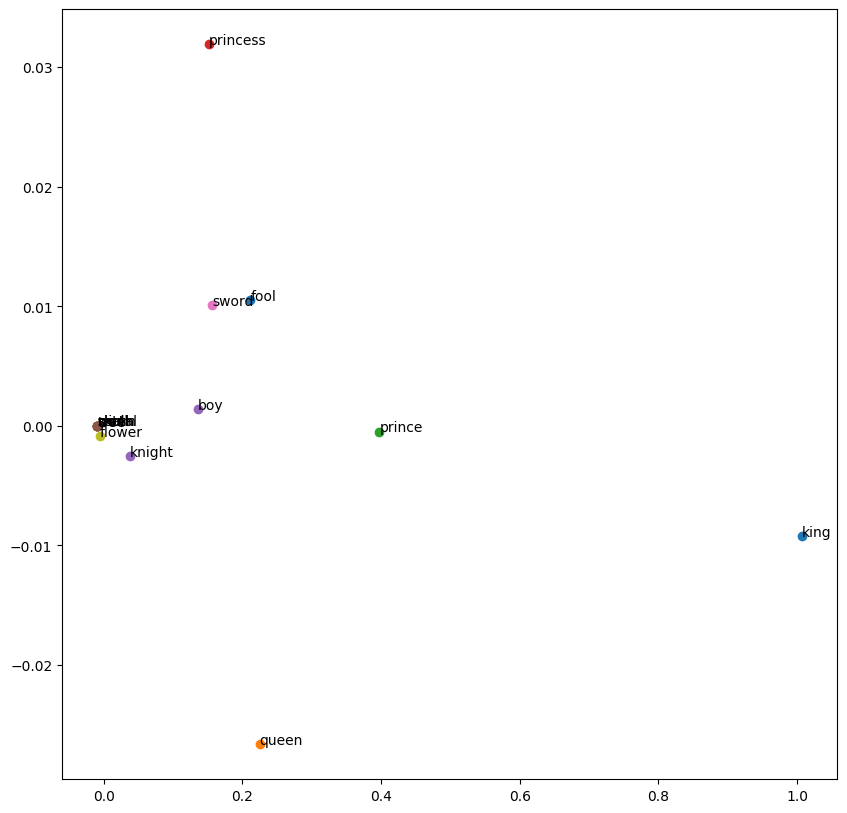

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))

for word in words:
  coord = reduced_embeddings[unique_dict[word]]
  plt.scatter(coord[0], coord[1])
  plt.annotate(word, (coord[0], coord[1]))

plt.savefig('embeddings.png')


#### The following is a way of displaying the vectors and their embeddings clearly. 


In [37]:
import matplotlib.pyplot as plt
from IPython.display import HTML, display

def plot_embeddings(words, number_dimensions, reduced_embeddings):
  # Get the embeddings for the given list of words
  embeddings = [reduced_embeddings[unique_dict[word]] for word in words]

  # Create a list to store the table rows
  rows = []

  # Plot the first x embeddings
  for word in words:
    embedding = reduced_embeddings[unique_dict[word]]

    # Convert the embedding array to a list and take the first 'number_dimensions' elements
    embedding = embedding.tolist()
    embedding = embedding[:number_dimensions]

    # Create a row with the word and the embeddings, followed by the color for each embedding
    row = [word] + [f"{e:.2f}" for e in embedding] 
    rows.append(row)

  # Use IPython's display function to display the table
  display(HTML(
      '<table><tr>{}</tr></table>'.format(
          '</tr><tr>'.join(
              '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in rows)
          )
  ))

words = ["king","queen"]
plot_embeddings(words, 5, reduced_embeddings)


king,1.01,-0.01
queen,0.22,-0.03


## Conclusion

The following has been an initial exploration of word embeddings.

While I would like to revisit this kind of work in future and I am sure there are many improvements I could make there are other projects to move on to.

Any feedback is very welcome at bwm.sturgeon@gmail.com

I hope reading this has been a clear and useful insight into how to train a basic word2vec model using skipgram with negative sampling.